In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

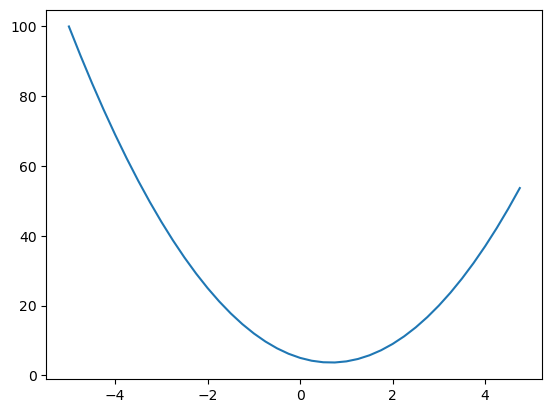

In [5]:
plt.plot(xs, ys)

In [6]:
h = 0.000000000001
x = 2 / 3
(f(x + h) - f(x)) / h


-0.0004440892098500626

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print(f"{d1=}, {d2=}")
print(f"slope: {(d2 - d1) / h}")


d1=4.0, d2=4.0001
slope: 0.9999999999976694


In [11]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def exp(self):
        out = Value(math.exp(self.data), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []

        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for v in reversed(topo):
            v._backward()


In [78]:
a = Value(2.0, label="a")
b = Value(4.0, label="b")
out = a / b
out.backward()

In [22]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

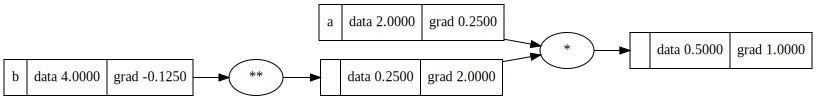

In [80]:
draw_dot(out)

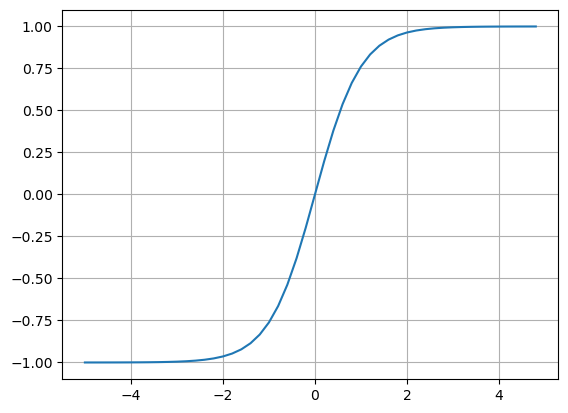

In [18]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()


In [81]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

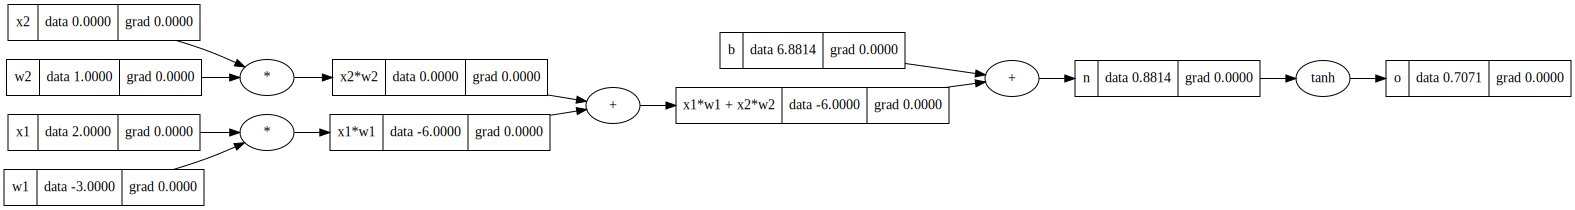

In [82]:
draw_dot(o)

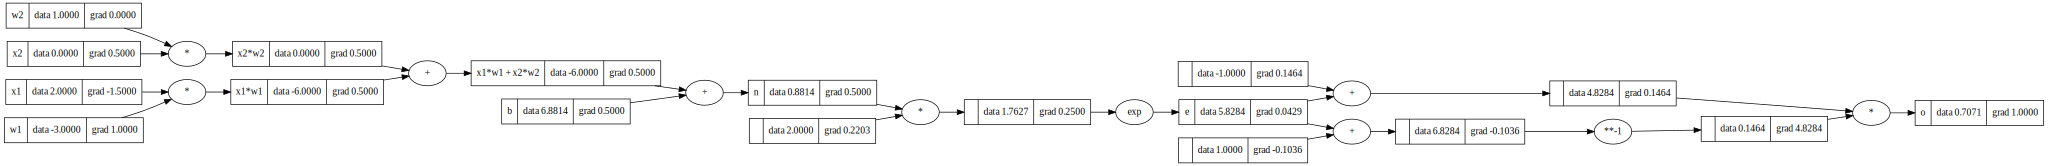

In [85]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"

e = (2 * n).exp()
e.label = "e"

o = (e - 1) / (e + 1)
o.label = "o"

o.backward()
draw_dot(o)


In [33]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()


In [36]:
topo = []
visited = set()


def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

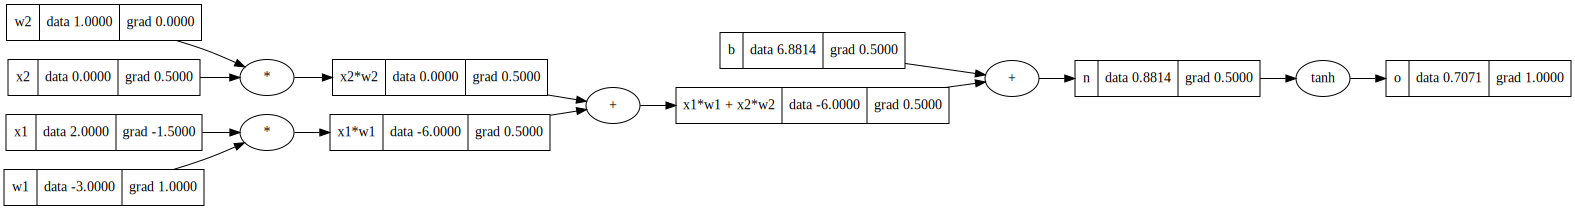

In [40]:
o.grad = 1.0

build_topo(o)
for v in topo:
    v._backward()

draw_dot(o)


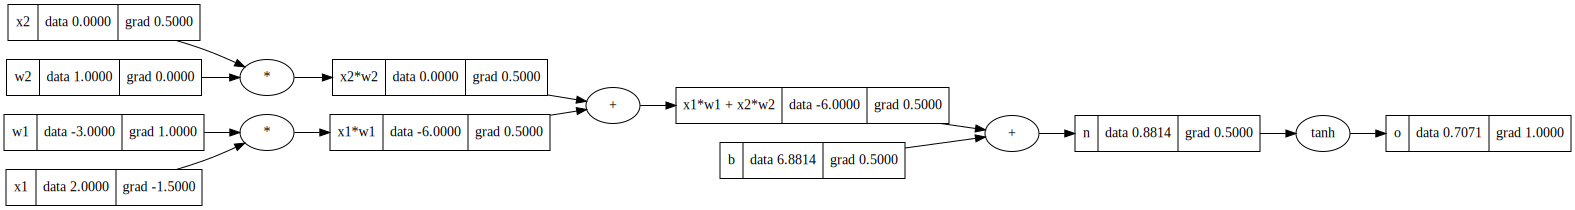

In [51]:
o.backward()
draw_dot(o)

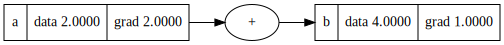

In [50]:
a = Value(2.0, label="a")
b = a + a
b.label = "b"
b.backward()
draw_dot(b)

In [1]:
import torch

In [8]:
x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.8813735870195432, requires_grad=True)
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
o.backward()
x1.grad, x2.grad, w1.grad, w2.grad, b.grad, o.data

(tensor(-1.5000),
 tensor(0.5000),
 tensor(1.0000),
 tensor(0.),
 tensor(0.5000),
 tensor(0.7071))

In [9]:
import random

In [41]:
class Neuron:
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x: list[Value]):
        act = sum((wi * xi for wi, xi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x: list[Value]):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin: int, nouts: list[int]):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [156]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=0.9666235670896899)

In [43]:
n.parameters()

[Value(data=-0.5749492711024158),
 Value(data=-0.27050996112996883),
 Value(data=0.0962197679578507),
 Value(data=-0.9978394323577588),
 Value(data=-0.6658198113078293),
 Value(data=-0.6706306666964013),
 Value(data=0.429182295284928),
 Value(data=-0.7263347381023273),
 Value(data=-0.4136244959854236),
 Value(data=-0.8109834158242815),
 Value(data=-0.8760117781736756),
 Value(data=0.6423631862539101),
 Value(data=0.3538417058897585),
 Value(data=0.3461880438331493),
 Value(data=-0.9716616940836464),
 Value(data=0.3582517370560194),
 Value(data=-0.9396328515894956),
 Value(data=0.44666541966576245),
 Value(data=-0.9698540483292901),
 Value(data=-0.4266880110072866),
 Value(data=-0.07267622794997708),
 Value(data=-0.8896096355918002),
 Value(data=-0.21032779892973585),
 Value(data=-0.43373026546120963),
 Value(data=0.2316432468088545),
 Value(data=0.778702735787755),
 Value(data=0.5756511518123282),
 Value(data=0.5618458674929308),
 Value(data=0.17221671575588027),
 Value(data=0.01683362

In [160]:
for k in range(100):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss: Value = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.0030245547648944755
1 0.0030067684536878537
2 0.00298918617233899
3 0.0029718044599974583
4 0.002954619933235439
5 0.0029376292839027357
6 0.002920829277052433
7 0.0029042167489346884
8 0.002887788605055855
9 0.0028715418183007458
10 0.0028554734271152337
11 0.002839580533747514
12 0.0028238603025451735
13 0.0028083099583067323
14 0.0027929267846849536
15 0.002777708122640535
16 0.002762651368944203
17 0.002747753974725202
18 0.0027330134440649765
19 0.0027184273326340217
20 0.002703993246370588
21 0.002689708840199576
22 0.002675571816790448
23 0.0026615799253525787
24 0.0026477309604667036
25 0.0026340227609514847
26 0.0026204532087636756
27 0.002607020227930867
28 0.002593721783515747
29 0.002580555880610626
30 0.002567520563361317
31 0.0025546139140195296
32 0.0025418340520223922
33 0.0025291791330987073
34 0.002516647348400546
35 0.002504236923659853
36 0.0024919461183687736
37 0.002479773224983245
38 0.0024677165681488843
39 0.002455774503948574
40 0.0024439454191710125
41 0.

In [161]:
ypred


[Value(data=0.9849017186716813),
 Value(data=-0.9889733980688075),
 Value(data=-0.9704198770655522),
 Value(data=0.9739884081134624)]